## Object creation example

In this notebook, an exaple for creating an object with a F-GRIN will be given. First I define the modules:

In [9]:
import torch
import matplotlib.pyplot as plt
import imageio
import io
from IPython.display import Image, display
import numpy as np
from typing import Callable
from dataclasses import dataclass
from tqdm import tqdm

from abc import ABC, abstractmethod

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

def FT(x):
    return torch.fft.fftshift(torch.fft.fft2(x))

def iFT(x):
    return torch.fft.ifft2(torch.fft.ifftshift(x))

Running on cuda.


Now I create the functions for visualization:

In [10]:
def show_z_scan_gif(volume: torch.Tensor, 
                    cmap: str = 'gray', 
                    duration: float = 0.1, 
                    pix_size: float = 1e-6):
    """
    Displays a loop showing all the slices of a volumetric object.

    Args:
        volume (_type_): _description_
        cmap (str, optional): _description_. Defaults to 'gray'.
        duration (float, optional): _description_. Defaults to 0.1.
        pix_size (_type_, optional): _description_. Defaults to None.
    """

    volume = volume.cpu().numpy() # type: ignore
    D = volume.shape[0]
    frames = []

    vmin = np.min(volume)
    vmax = np.max(volume)

    for z in range(D):
        fig, ax = plt.subplots(figsize=(4, 4), dpi=80)
        im = ax.imshow(volume[z], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.axis('off')

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)

        z_pos = (z - D / 2) * pix_size * 1e6
        label = f"Z = {z_pos:.2f} µm"

        ax.text(0.05, 0.95, label, transform=ax.transAxes,
                fontsize=10, color='white', ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        frames.append(imageio.v3.imread(buf))
        buf.close()

    # Create looping GIF
    gif_bytes = io.BytesIO()
    imageio.mimsave(gif_bytes, frames, format='gif', duration=duration, loop=0) # type: ignore
    gif_bytes.seek(0)

    display(Image(data=gif_bytes.read(), format='gif'))

I define the pseudo F-GRIN sample (ideally should be defined as shown by the article writen by David H Lippman et al. named [Freeform gradient-index media: a new frontier in freeform optics](https://pubmed-ncbi-nlm-nih-gov.tudelft.idm.oclc.org/34809097/)):

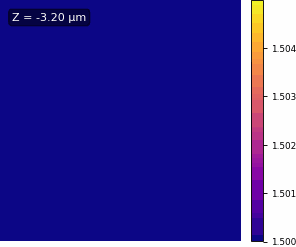

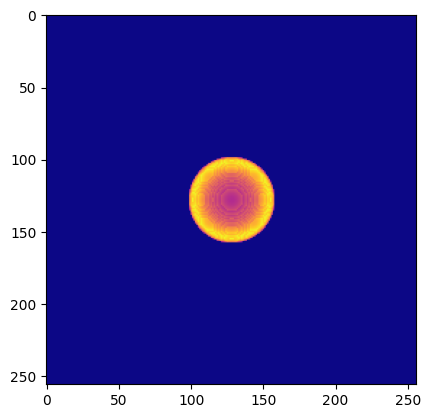

In [11]:
pix_size = 0.1e-6
D, H, W = (64,256,256)

Z, Y, X = torch.meshgrid(
    pix_size*(torch.arange(D, device=device) - D/2),
    pix_size*(torch.arange(H, device=device) - H/2),
    pix_size*(torch.arange(W, device=device) - W/2),
    indexing='ij'
)

λ = 535e-9
rad = 3e-6
n_a = 1.5
dn = 0.005

sample_3D = (X**2 + Y**2 + Z**2)**3 * ((X**2 + Y**2 + Z**2)<rad**2)
#sample_3D = 4 * ((X**2 + Y**2 ))
sample_3D -= sample_3D.min()
sample_3D /= sample_3D.max()
sample_3D = sample_3D * dn + n_a

show_z_scan_gif(sample_3D, cmap='plasma', duration=0.1, pix_size=pix_size)
plt.figure()
plt.imshow(sample_3D.sum(axis=0).cpu().numpy(), cmap='plasma')
plt.show()

I create the functions and classes to perform the propagation:

In [ ]:
from turtle import Shape


class Simparams:
    """
    Class for storing the most used variables during the simulation and return the coordinates.
    """
    def __init__(self, 
                 pix_size : float,
                 shape : tuple[int, int, int],
                 λ : float,
                 device : str,
                 n_0 : float = 1) -> None:
        self.pix_size = pix_size
        self.shape = shape
        self.λ = λ
        self.device = device
        self.n_0 = n_0
        self.D, self.H, self.W = shape 
    
    def real_coord(self) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.pix_size * (torch.arange(self.W, device=self.device) - self.W / 2) 
        y = self.pix_size * (-torch.arange(self.H, device=self.device) + self.H / 2) 
        Y, X = torch.meshgrid(y,x, indexing='ij')
        return Y, X
    
    def f_coord(self) -> tuple[torch.Tensor, torch.Tensor]:
        f_pix_size = (1 / (self.H * self.pix_size), 1 / (self.W * self.pix_size))
        fx = f_pix_size[1] * (torch.arange(self.W, device=self.device) - self.W / 2) 
        fy = f_pix_size[0] * (-torch.arange(self.H, device=self.device) + self.H / 2) 
        FY, FX = torch.meshgrid(fy,fx, indexing='ij')
        return FY, FX


def as_propagator(FY : torch.Tensor,
                  FX : torch.Tensor,
                  n : float | complex | torch.Tensor,
                  z: float,
                  λ : float
                  ) -> torch.Tensor:
    return torch.exp(2j * torch.pi * z * 
                     torch.sqrt(((n / λ)**2 - FX**2 - FY**2).to(torch.complex128)))


def propagation(u_i: torch.Tensor,
                vol_n: torch.Tensor,
                propagator: Callable,
                sim_params: Simparams,
                ) -> torch.Tensor:

    FY, FX = sim_params.real_coord()
    u_o = u_i.detach().clone()
    
    phase_vol = torch.exp(2j * torch.pi * (sim_params.n_0-vol_n) /  λ)
    
    prop_fact = propagator(FY, FX, sim_params.n_0, sim_params.pix_size/2, sim_params.λ)
    for i in range(D):
        u_o = iFT(FT(u_o) * prop_fact)
        u_o *= phase_vol[i]
        u_o = iFT(FT(u_o) * prop_fact)
    return u_o

Now we obtain the real output wave:

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from fgrinmet.essentials.representation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


cuda:0


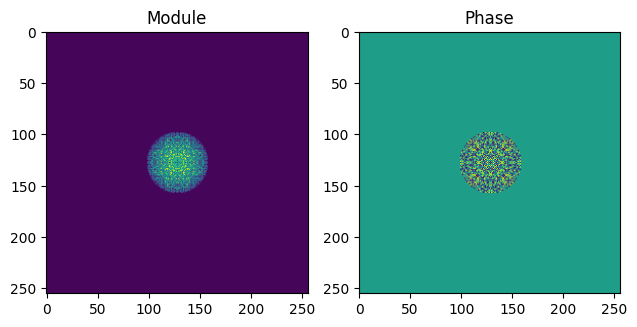

In [18]:


sim_params = Simparams(pix_size, (D, H, W), λ, device, n_a)


#Y, X = sim_params.real_coord()
print(Y.device)
#gauss = torch.exp(-X*X-Y*Y).detach().cpu().numpy()
#u_i = torch.Tensor(gauss, device=device, dtype=torch.complex128)
#u_i = torch.exp(-X*X-Y*Y).detach()
u_i =  torch.ones((H, W), device=device, dtype=torch.complex128)
u_o_real = propagation(u_i, sample_3D, as_propagator, sim_params)

show_complex(u_o_real)

And finally we apply the reconstruction:

Optimizing: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s, loss=2.225084e+00]


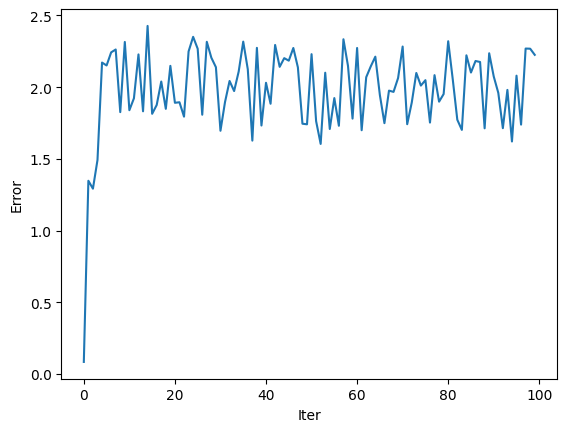

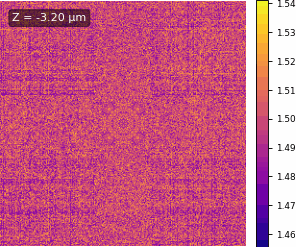

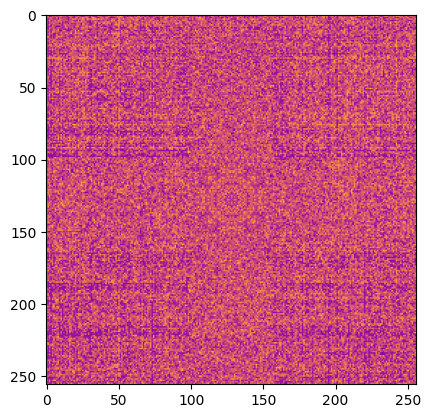

In [15]:
def complex_mse_loss(input, target):
    return ((input.real - target.real)**2 + (input.imag - target.imag)**2).mean()

sample_guess = torch.full((D,H,W), fill_value=sim_params.n_0, device=device, requires_grad=True)
loss_f = complex_mse_loss

num_steps = 100
optimizer = torch.optim.Adam([sample_guess], lr=1e-3)
losses = []
with tqdm(range(num_steps), desc="Optimizing") as pbar:
    for step in pbar:
        optimizer.zero_grad()
        u_o_guess = propagation(u_i, sample_guess, as_propagator, sim_params)
        loss = complex_mse_loss(u_o_guess, u_o_real)
        loss.backward()
        optimizer.step()
        
        # Update tqdm postfix with current loss
        pbar.set_postfix(loss=f"{loss.item():.6e}")

        losses.append(loss.detach().cpu().float())

plt.figure()
plt.plot(losses)
plt.xlabel("Iter")
plt.ylabel("Error")
plt.show()

sample_guess_show = sample_guess.detach()
show_z_scan_gif(sample_guess_show, cmap='plasma', duration=0.1, pix_size=pix_size)
plt.figure()
plt.imshow(sample_guess_show.sum(axis=0).cpu().numpy(), cmap='plasma')
plt.show()